In [0]:
from __future__ import print_function

import logging
import sys
root_logger = logging.getLogger()
stdout_handler = logging.StreamHandler(sys.stdout)
root_logger.addHandler(stdout_handler)
root_logger.setLevel(logging.DEBUG)

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

# Convolutional NN - Autoencoder

In this notebook we set up an autoencoder that uses convolutional instead of fully connected hidden layers.

### Why convolutions?

**Drawbacks of using fully connected layers on image input** 

* FC layers don't exploit local structure
* FC layer is not equivariant under translation (translated pattern can correspond to completely different feature)
* For big images FC layers have huge number of parameters (for example for 1000 hidden units, 1000 x 1000 x 3 image such layer has ~3 billion weights)

**CNN layers:**

* Extract local features
* Are equivariant to translation
* Have lot less parameters, since they share kernel over the whole input image 


## Contents:

* [Network definition](#model_definition)

* [Fitting and visualization](#fitting_visualization)

In [0]:
### Plotting utils

In [0]:
def plot_two_img_rows(X1, X2, title, j=5, do_reshape=True):
  f, axes = plt.subplots(2, j, figsize=(10, 20 / j))
  f.suptitle(title)
  for k, x in zip(range(2), [X1, X2]):
    for i in range(j):
      ax = axes[k, i]
      img = x[i]
      if do_reshape:
        img = img[i, :].reshape(28, 28)
      ax.imshow(img, cmap='gray')
      ax.axis('off')
  plt.show()
  

def display_reconstruction_results(model, val_iter):
  print('validation set metrics:', conv_autoencoder.score(val_iter, eval_metric='rmse'))
  example_batch = mx.io.ResizeIter(val_iter, 1).next().data[0].asnumpy()
  reconstructed_batch = model.predict(mx.io.ResizeIter(val_iter, 1)).asnumpy()
  
  example_images = example_batch[:5].reshape(-1, 28, 28)
  reconstructed_images = reconstructed_batch[:5].reshape(-1, 28, 28)
  mse_errors = np.mean((example_images - reconstructed_images) ** 2, axis=(1,2))
  print('Examples RMSE reconstruction error:')
  print(np.around(np.sqrt(mse_errors), 4))
  plot_two_img_rows(reconstructed_images, example_images, 'conv autoencoder reconstruction \nlower row: original images', do_reshape=False)

### Data setup

Note we have to reshape data to make 2d convolution possible

In [4]:
batch_size = 32
mnist = mx.test_utils.get_mnist()

train_iter = mx.io.NDArrayIter(data=mnist['train_data'], label=mnist['train_data'], batch_size=batch_size, shuffle=True, label_name='data')
val_iter = mx.io.NDArrayIter(data=mnist['test_data'], label=mnist['test_data'], batch_size=batch_size, label_name='data')

train-labels-idx1-ubyte.gz exists, skipping download
train-images-idx3-ubyte.gz exists, skipping download
t10k-labels-idx1-ubyte.gz exists, skipping download
t10k-images-idx3-ubyte.gz exists, skipping download


In [5]:
mnist.keys()

dict_keys(['train_data', 'train_label', 'test_data', 'test_label'])

In [0]:
input_size = 784
hidden_size = 20 

training_param_args = {
  'num_epoch': 10,
  'eval_metric': 'rmse',
  'optimizer_params':{'learning_rate': 0.33}
}

<a id='model_definition'></a>

In [0]:
def conv_autoencoder_loss(input_size, hidden_size, num_filter, kernel):
  data = sym.Variable('data')
  weights = sym.Variable(name='weights', 
                         shape=(hidden_size, num_filter, *kernel),
                         init=mx.init.Xavier())
  bias_out = sym.Variable(name='bias_out', shape=(1, 1, *input_size), init=mx.init.Zero())
  
  hid_in = sym.Convolution(
    data=data,
    weight=weights,
    num_filter=hidden_size,
    dilate=(3,3),
    kernel=kernel,
    name='hidden_in')
  
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  
  hid_out = sym.Deconvolution(
    codes,
    weights,
    dilate=(3,3),
    num_filter=num_filter,
    kernel=kernel,
    name='hidden_out')
  
  out = sym.broadcast_add(
    sym.Activation(hid_out, act_type='relu', name='out'),
    bias_out
  )
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=out, label=data)
  )

In [8]:
conv_autoencoder = mod.Module(
  symbol=conv_autoencoder_loss(
    input_size=(28, 28),
    hidden_size=1,
    num_filter=1,
    kernel=(3,3)),
  label_names=['data'],
  context=ctx
)

mx.viz.print_summary(conv_autoencoder.symbol, shape={'data': (1, 1, 28, 28)})

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          1x28x28                 0                                           
________________________________________________________________________________________________________________________
hidden_in(Convolution)                              1x22x22                 10          data                            
________________________________________________________________________________________________________________________
codes(Activation)                                   1x22x22                 0           hidden_in                       
________________________________________________________________________________________________________________________
hidden_out(Deconvolution)       

<a id='fitting_visualization'></a>

In [9]:
%time conv_autoencoder.fit(train_iter, eval_data=val_iter, **training_param_args)

Epoch[0] Train-rmse=0.062207
Epoch[0] Time cost=3.729
Epoch[0] Validation-rmse=0.044133
Epoch[1] Train-rmse=0.045620
Epoch[1] Time cost=3.629
Epoch[1] Validation-rmse=0.043839
Epoch[2] Train-rmse=0.045442
Epoch[2] Time cost=3.689
Epoch[2] Validation-rmse=0.043805
Epoch[3] Train-rmse=0.045413
Epoch[3] Time cost=3.666
Epoch[3] Validation-rmse=0.043808
Epoch[4] Train-rmse=0.045408
Epoch[4] Time cost=3.622
Epoch[4] Validation-rmse=0.043813
Epoch[5] Train-rmse=0.045408
Epoch[5] Time cost=3.622
Epoch[5] Validation-rmse=0.043817
Epoch[6] Train-rmse=0.045408
Epoch[6] Time cost=3.644
Epoch[6] Validation-rmse=0.043819
Epoch[7] Train-rmse=0.045409
Epoch[7] Time cost=3.622
Epoch[7] Validation-rmse=0.043820
Epoch[8] Train-rmse=0.045409
Epoch[8] Time cost=3.640
Epoch[8] Validation-rmse=0.043820
Epoch[9] Train-rmse=0.045409
Epoch[9] Time cost=3.648
Epoch[9] Validation-rmse=0.043820
CPU times: user 41.2 s, sys: 21.1 s, total: 1min 2s
Wall time: 41.1 s


validation set metrics: [('rmse', 0.043820148708816536)]
Examples RMSE reconstruction error:
[0.0745 0.0114 0.0108 0.0121 0.0113]


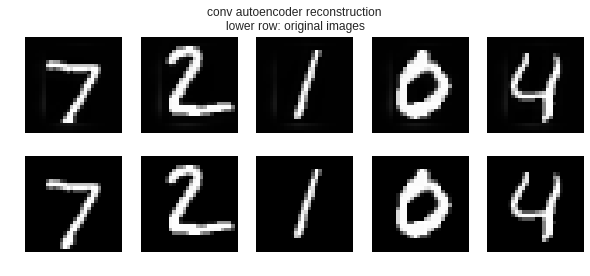

In [10]:
display_reconstruction_results(conv_autoencoder, val_iter)